# Evolución de los costes medios horarios en los últimos años

## Objetivo

Vamos a intentar visualizar como ha variado el perfil de precios medios horarios en los últimos años. Vamos a comprobar si realmente se está formando la famosa "curva de pato"

Esta idea ha surgido por este tuit de @arivero, que comentó el tuit y el gráfico de @JomauJulien

https://x.com/arivero/status/1750480902470107143?s=20


En esta entrada https://en.wikipedia.org/wiki/Duck_curve se puede leer sobre como nació esta curva y a qué se debe, cuales son las dinámicas que le generan..


## Import

Tenemos un montón de librerias con las que vamos a trabajar, no he tenido ningún problema en instalar aquellas no disponibles en el entorno Anaconda con el que trabajo por medio de `pip install libreria` realizado desde un terminal abierto desde el entorno `env`.

In [113]:
import os.path as pth
import time
import calendar
import sys

import pandas as pd
import numpy as np

import requests
import json

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, WeekdayLocator, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange, num2date, date2num)
import matplotlib.patches as mpatches
import matplotlib.units as munits

import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

from datetime import datetime,timedelta,date
import seaborn as sns
%matplotlib inline

sys.path.append("/Users/mharias/Documents/proyectos/mylibs") # directorio de acceso a librerías auxiliares

from pass_esios import token_esios
from herramientas import download_esios, download_ree
import locale

In [114]:
path_proyecto = '/Users/mharias/documents/proyectos/consumo_luz/'

# Curva de pato

In [109]:
indicadores = [805] # este es indicador de esios que nos indica el coste horario

Preparamos un rango de fechas entre los extremos del período que queremos estudiar

In [110]:
rango_fechas = pd.Series(pd.date_range(start='2018-01-01',end='2023-12-31',
                                       freq=timedelta(days=1)))

No puedes solicitar a esios un rango demasiado amplio, no recuerdo el límite,así que limitamos a 100*24 datos por cada llamada

In [68]:
segmentos_fechas = (rango_fechas
 .groupby(np.arange(len(rango_fechas))//100)
 .agg(['first','last'])
)

Bajamos los datos y los agregamos a una lista, tipo `list`

In [69]:
lista=[]
for i in segmentos_fechas.index:
    inicio = segmentos_fechas.loc[i,'first'].strftime("%Y-%m-%d")
    fin = segmentos_fechas.loc[i,'last'].strftime("%Y-%m-%d")
    print (f"Descargando desde {inicio}, hasta {fin}")
    lista.append(download_esios(token_esios,indicadores,inicio,fin,time_trunc='hour'))

Descargando desde 2018-01-01, hasta 2018-04-10
Descargando desde 2018-04-11, hasta 2018-07-19
Descargando desde 2018-07-20, hasta 2018-10-27
Descargando desde 2018-10-28, hasta 2019-02-04
Descargando desde 2019-02-05, hasta 2019-05-15
Descargando desde 2019-05-16, hasta 2019-08-23
Descargando desde 2019-08-24, hasta 2019-12-01
Descargando desde 2019-12-02, hasta 2020-03-10
Descargando desde 2020-03-11, hasta 2020-06-18
Descargando desde 2020-06-19, hasta 2020-09-26
Descargando desde 2020-09-27, hasta 2021-01-04
Descargando desde 2021-01-05, hasta 2021-04-14
Descargando desde 2021-04-15, hasta 2021-07-23
Descargando desde 2021-07-24, hasta 2021-10-31
Descargando desde 2021-11-01, hasta 2022-02-08
Descargando desde 2022-02-09, hasta 2022-05-19
Descargando desde 2022-05-20, hasta 2022-08-27
Descargando desde 2022-08-28, hasta 2022-12-05
Descargando desde 2022-12-06, hasta 2023-03-15
Descargando desde 2023-03-16, hasta 2023-06-23
Descargando desde 2023-06-24, hasta 2023-10-01
Descargando d

..agregamos todos los elementos de la lista en un `DataFrame`

In [70]:
raw = pd.concat(lista, ignore_index=True )

In [71]:
raw

,value,datetime,datetime_utc,tz_time,geo_id,geo_name,name,short_name
0,6.74,2018-01-01T00:00:00.000+01:00,2017-12-31T23:00:00Z,2017-12-31T23:00:00.000Z,8741,Península,Precio medio horario componente mercado diario,Mercado Diario
1,4.74,2018-01-01T01:00:00.000+01:00,2018-01-01T00:00:00Z,2018-01-01T00:00:00.000Z,8741,Península,Precio medio horario componente mercado diario,Mercado Diario
2,3.66,2018-01-01T02:00:00.000+01:00,2018-01-01T01:00:00Z,2018-01-01T01:00:00.000Z,8741,Península,Precio medio horario componente mercado diario,Mercado Diario
3,2.30,2018-01-01T03:00:00.000+01:00,2018-01-01T02:00:00Z,2018-01-01T02:00:00.000Z,8741,Península,Precio medio horario componente mercado diario,Mercado Diario
4,2.30,2018-01-01T04:00:00.000+01:00,2018-01-01T03:00:00Z,2018-01-01T03:00:00.000Z,8741,Península,Precio medio horario componente mercado diario,Mercado Diario
...,...,...,...,...,...,...,...,...
52579,101.30,2023-12-31T19:00:00.000+01:00,2023-12-31T18:00:00Z,2023-12-31T18:00:00.000Z,8741,Península,Precio medio horario componente mercado diario,Mercado Diario
52580,92.97,2023-12-31T20:00:00.000+01:00,2023-12-31T19:00:00Z,2023-12-31T19:00:00.000Z,8741,Península,Precio medio horario componente mercado diario,Mercado Diario
52581,85.49,2023-12-31T21:00:00.000+01:00,2023-12-31T20:00:00Z,2023-12-31T20:00:00.000Z,8741,Península,Precio medio horario componente mercado diario,Mercado Diario
52582,74.74,2023-12-31T22:00:00.000+01:00,2023-12-31T21:00:00Z,2023-12-31T21:00:00.000Z,8741,Península,Precio medio horario componente mercado diario,Mercado Diario


In [72]:
print (f"Descripción del id {indicadores[0]}: {raw.name.unique()[0]}")

Descripción del id 805: Precio medio horario componente mercado diario 


y ahora, a partir de esos datos vamos a generar un `DataFrame`con el formato y valores que necesitamos

In [111]:
data = (raw
 .assign(hora = lambda df_: pd #formateamos campo fecha, desde un str con diferencia horaria a un naive
                      .to_datetime(df_['datetime'],utc=True)  # con la fecha local
                      .dt
                      .tz_convert('Europe/Madrid')
                      .dt
                      .tz_localize(None)
        )
 .rename({'value':'coste'},axis=1) # cambiamos el nombre de la columna value por coste, solo por capricho
 .loc[:,['hora','coste']] # nos quedamos con estas dos columnas
 .assign(year = lambda df_ : df_['hora'].dt.year)  # sacamos el año
 .assign(hora = lambda df_ : df_['hora'].dt.hour)  #sacamos la hora
 .groupby(['hora','year']).mean()  #agrupamos por año y hora y sacamos la media de las 365 valores horarios del año
 .reset_index() # necesario para mover año y hora del index a las columnas
 .assign (coste_norm = lambda df_ : df_.groupby(['year']).transform(lambda x : x/x.iloc[0]).coste)
        # con esta ultima funcion normalizamos los valores medios a la hora 0..asi las series comienzan en 1


 

                 )

asi queda el DataFrame:

In [112]:
data

,hora,year,coste,coste_norm
0,0,2018,56.209726,1.000000
1,0,2019,47.582411,1.000000
2,0,2020,33.451776,1.000000
3,0,2021,112.961863,1.000000
4,0,2022,176.798712,1.000000
...,...,...,...,...
139,23,2019,48.172959,1.012411
140,23,2020,34.903388,1.043394
141,23,2021,115.029397,1.018303
142,23,2022,177.985644,1.006713


Solo queda pintarlo

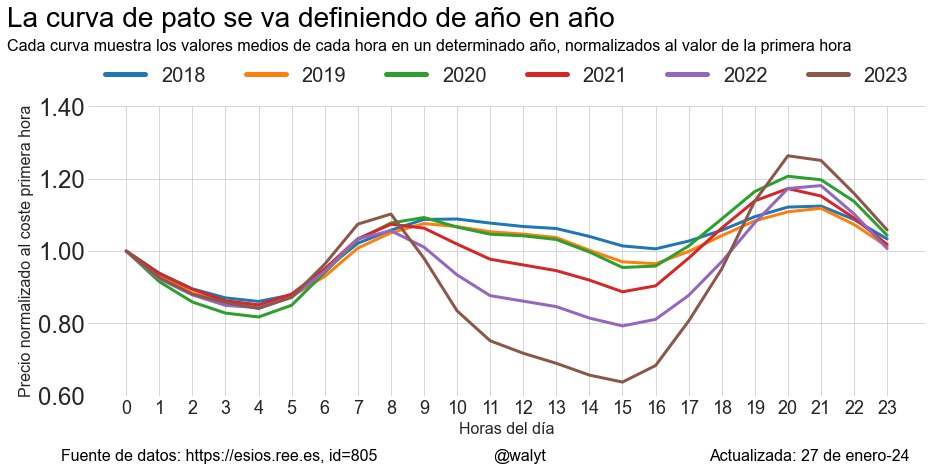

In [108]:
locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')
titulo =f"La curva de pato se va definiendo de año en año"
fuente = f'https://esios.ree.es, id={indicadores[0]}'
autor='@walyt'
path_proyecto = '/Users/mharias/documents/proyectos/consumo_luz/'
renovables = ['Eólica','Solar fotovoltaica']

color=sns.color_palette('tab10')

f, ax = plt.subplots(figsize=(15,6))

sns.set_style(style='white')
scatter = sns.lineplot(data=data,
            x='hora',
            y='coste_norm',
            hue='year',
            palette=color[:6],
            lw=3
            
            #label=['Máximo','Media','Mediana']
              )

ax.xaxis.set_tick_params(labelsize=18,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=24,width=0,rotation=0,pad=-0)
#ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v/1000:,.0f}GWh'.replace(',','.')))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v:,.2f}'.replace(',','.')))
#ax.set_ylim((0,1.4))
ax.set_yticks([.6,.8,1,1.2,1.4])

sns.despine(left=True, bottom=True)
ax.grid(visible=True,axis='both',zorder=0)


ax.set_xlabel('Horas del día',fontsize=16)
ax.set_ylabel('Precio normalizado al coste primera hora',fontsize=16)
f.subplots_adjust(top=.77,bottom=0.1)

ax.set_xticks(range(0,24))


#leyenda 
handles, labels = ax.get_legend_handles_labels()
leyenda=ax.legend(handles,
          labels,
                  fontsize=20,
                  markerscale=2.5,
                  loc=9,
                  ncol=len(handles),
                  frameon=False,
                  bbox_to_anchor=(.5,1.2))
for line in leyenda.get_lines():
    line.set_linewidth(5)
    
#textos auxiliares
f.suptitle('{}'.format(titulo),fontsize=28,color='black',y=1.0,x=0.05,ha='left')
f.text(0.05, .91, 'Cada curva muestra los valores medios de cada hora en un determinado año, normalizados al valor de la primera hora', 
       horizontalalignment='left',
       verticalalignment='center',
       fontsize=16,color='black')

f.text(0.1, -0.04, 'Fuente de datos: {}'.format(fuente), horizontalalignment='left',
             verticalalignment='center', fontsize=16,color='black')
f.text(0.5,-0.04,'{}'.format(autor),
                 verticalalignment='center',fontsize=16,horizontalalignment='left',color='black')

f.text(0.7,-0.04,f'Actualizada: {datetime.today().strftime("%-d de %B-%y")}',
       verticalalignment='center',fontsize=16,horizontalalignment='left',color='black')



path_imagen = '{}img/figura_pato.png'.format(path_proyecto)
f.savefig(path_imagen,dpi=288,bbox_inches='tight')

Efectivamente se está perfilando la "curva de pato"...